In [0]:
!git clone https://github.com/phanideepgampa/stacked-capsule-networks

Cloning into 'stacked-capsule-networks'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 108 (delta 51), reused 65 (delta 21), pack-reused 0
Receiving objects: 100% (108/108), 22.09 MiB | 22.05 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [1]:
import math
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
import torchvision.transforms.functional as F1

from torchvision import datasets
from torch.nn.utils.rnn import pad_sequence
from torch.autograd import Variable
from torch.nn import Parameter
from copy import deepcopy
!pip install kornia
from kornia.geometry.transform import warp_affine
print("CUDA is available:",torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount("./gdrive/")

     |████████████████████████████████| 143kB 5.0MB/s 
CUDA is available: True
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./gdrive/


## Dataset

In [2]:
#!git clone https://github.com/knamdar/data

class MNIST():
    def __init__(self, batch_size=128):
        super(MNIST, self).__init__()
        im_transforms = tt.Compose([tt.ToTensor()])#, transforms.Normalize()])
        self.train_data = datasets.MNIST("./data/", train=True, download=True, transform=im_transforms)
        self.test_data = datasets.MNIST("./data/", train=False, download=True, transform=im_transforms)

        self.trainloader = torch.utils.data.DataLoader(self.train_data, batch_size=batch_size, shuffle=True)
        self.testloader = torch.utils.data.DataLoader(self.test_data, batch_size=batch_size, shuffle=True)
        return
mnist = MNIST()

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
class SVHN():
    def __init__(self, batch_size=128):
        super(SVHN, self).__init__()
        im_transforms = transforms.Compose([transforms.ToTensor()])
        self.train_data = datasets.SVHN("./", split='train', download=True, transform=im_transforms)
        self.test_data = datasets.SVHN("./", split='test', download=True, transform=im_transforms)

        self.trainloader = torch.utils.data.DataLoader(self.train_data, batch_size=batch_size, shuffle=True)
        self.testloader = torch.utils.data.DataLoader(self.test_data, batch_size=batch_size, shuffle=True)
        return
svhn = SVHN()

Using downloaded and verified file: ./train_32x32.mat
Using downloaded and verified file: ./test_32x32.mat


## PCAE

In [0]:
class PCAE(nn.Module):
    def __init__(self, num_capsules=24, template_size=11, num_templates=24,num_feature_maps=24):
        super(PCAE,self).__init__()
        self.num_capsules = num_capsules
        self.num_feature_maps = num_feature_maps       
        self.capsules = nn.Sequential(nn.Conv2d(1,128,3,stride=2),
                            nn.ReLU(),
                        nn.Conv2d(128,128,3,stride=2),
                            nn.ReLU(),
                        nn.Conv2d(128,128,3,stride=1),
                            nn.ReLU(),
                        nn.Conv2d(128,128,3,stride=1),
                            nn.ReLU(),
                        nn.Conv2d(128,num_capsules*num_feature_maps,1,stride=1))

        self.templates = [ nn.Parameter(torch.randn(1,template_size,template_size))
                            for _ in range(num_templates)]
        self.soft_max = nn.Softmax(2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.to_pil = tt.ToPILImage()
        self.to_tensor = tt.ToTensor()
        self.epsilon = torch.tensor(1e-6)
        
    def forward(self,x,mode='train'):
        outputs = self.capsules(x)
        outputs = outputs.view(-1,self.num_capsules,self.num_feature_maps,*outputs.size()[2:]) #(B,M,24,2,2)
        attention = outputs[:,:,-1,:,:].unsqueeze(2)
        attention_soft = self.soft_max(attention.view(*attention.size()[:3],-1)).view_as(attention)
        feature_maps = outputs[:,:,:-1,:,:]
        part_capsule_param = torch.sum(torch.sum(feature_maps*attention_soft,dim=-1),dim=-1) #(B,M,23)

        if mode == 'train':
            noise_1 = torch.FloatTensor(*part_capsule_param.size()[:2]).uniform_(-2,2).to(device)
        else:
            noise_1 = torch.zeros(*part_capsule_param.size()[:2]).to(device)
        x_m,d_m,c_z = self.relu(part_capsule_param[:,:,:6]),self.sigmoid(part_capsule_param[:,:,6]+noise_1).view(*part_capsule_param.size()[:2],1),self.relu(part_capsule_param[:,:,7:])

        # Affine Transform
        B, _, _, target_size = x.size()
        transformed_templates = [F.grid_sample(self.templates[i].repeat(B,1,1,1).to(device), # sce.to(device) could not transfrom self.templates to "cuda"
                                               F.affine_grid(
                                                   self.geometric_transform(x_m[:,i,:]),  # pose
                                                   torch.Size((B, 1, target_size, target_size)) # size
                                               ))
                                 for i in range(self.num_capsules)]
        transformed_templates = torch.cat(transformed_templates, 1)
        mix_prob = self.soft_max(d_m*transformed_templates.view(*transformed_templates.size()[:2],-1)).view_as(transformed_templates)
        detach_x = x.data
        std= detach_x.view(*x.size()[:2],-1).std(-1).unsqueeze(1)  #(B,1,1)
        std = std*1 + self.epsilon
        multiplier = (std*math.pi*2).sqrt().reciprocal().unsqueeze(-1)  #(B,1,1,1)
        power_multiply = (-(2*(std**2))).reciprocal().unsqueeze(-1) #(B,1,1,1)
        gaussians = multiplier*((((detach_x-transformed_templates)**2)*power_multiply).exp()) #(B,M,28,28)
        pre_ll = (gaussians*mix_prob*1.0)+self.epsilon
        log_likelihood = torch.sum(pre_ll,dim=1).log().sum(-1).sum(-1).mean() #scalar loss
        x_m_detach = x_m.data
        d_m_detach = d_m.data
        template_det = []
        for template in self.templates:
            template_det.append(template.data.view(1,-1))
        template_detached = torch.cat(template_det,0).unsqueeze(0).expand(x_m_detach.shape[0],-1,-1).to(device) #(B,M,11*11)
        input_ocae = torch.cat([d_m_detach,x_m_detach,template_detached,c_z],-1) #(B,M,144)
        
        return log_likelihood,input_ocae,x_m_detach,d_m_detach

    @staticmethod
    def geometric_transform(pose_tensor, similarity=False, nonlinear=True):
        """Convers paramer tensor into an affine or similarity transform.
        This function is adapted from:
        https://github.com/akosiorek/stacked_capsule_autoencoders/blob/master/capsules/math_ops.py

        Args:
        pose_tensor: [..., 6] tensor.
        similarity: bool.
        nonlinear: bool; applies nonlinearities to pose params if True.

        Returns:
        [..., 2, 3] tensor.
        """

        scale_x, scale_y, theta, shear, trans_x, trans_y = torch.split(pose_tensor, 1, -1)

        if nonlinear:
            scale_x, scale_y = torch.sigmoid(scale_x) + 1e-2, torch.sigmoid(scale_y) + 1e-2
            trans_x, trans_y, shear = torch.tanh(trans_x * 5.),  torch.tanh(trans_y * 5.), torch.tanh(shear * 5.)
            theta *= 2. * math.pi
        else:
            scale_x, scale_y = (abs(i) + 1e-2 for i in (scale_x, scale_y))

        c, s = torch.cos(theta), torch.sin(theta)

        if similarity:
            scale = scale_x
            pose = [scale * c, -scale * s, trans_x, scale * s, scale * c, trans_y]

        else:
            pose = [
                scale_x * c + shear * scale_y * s, -scale_x * s + shear * scale_y * c,
                trans_x, scale_y * s, scale_y * c, trans_y
            ]

        pose = torch.cat(pose, -1)

        # convert to a matrix
        shape = list(pose.shape[:-1])
        shape += [2, 3]
        pose = torch.reshape(pose, shape)

        return pose
class PCAE_LOSS(nn.Module):
    def __init__(self):
        super(PCAE_LOSS,self).__init__()
    def forward(self,output_pcae):
        img_lik,_,_,_ = output_pcae
        return -img_lik

## My PCAE

In [0]:
'''
Part Capsule Autoencoder
'''

class PCAE(nn.Module):
    def __init__(self, num_capsules=24, template_size=11,num_feature_maps=24):
        super(PCAE,self).__init__()
        self.num_capsules = num_capsules
        self.num_feature_maps = num_feature_maps       
        self.capsules = nn.Sequential(
                                       nn.Conv2d(1,128,3,stride=2),
                                       nn.ReLU(),
                                       nn.Conv2d(128,128,3,stride=2),
                                       nn.ReLU(),
                                       nn.Conv2d(128,128,3,stride=1),
                                       nn.ReLU(),
                                       nn.Conv2d(128,128,3,stride=1),
                                       nn.ReLU(),
                                       nn.Conv2d(128,num_capsules*num_feature_maps,1,stride=1)
                                    )

        self.templates = nn.Parameter(torch.rand((self.num_capsules, 2, template_size, template_size))) # [M, C+1, 11, 11]

    def forward(self, x):
        batch_size = x.shape[0] # [B, C, 28, 28]
        #x_shape = x.shape
        #x = x.view(*x_shape[0:2], -1) # [B, C, 28*28]
        #x = (x - x.mean(dim=2).unsqueeze(-1))/x.std(dim=2).unsqueeze(-1)
        #x = x.view(x_shape)
        epsilon = 1e-5
        cnn_enc = self.capsules(x) # [B, 24*24, 2, 2]
        cnn_enc = cnn_enc.view(batch_size, self.num_capsules, self.num_feature_maps, *cnn_enc.shape[-2:]) # [B, M, 24, 2, 2]
        att_mask = cnn_enc[:,:,-1,:,:] # Last channel used as attention mask
        att_mask = torch.softmax(att_mask.view(*att_mask.shape[0:2],-1),2) # Reshaping last (2,2) to flat 4 and apply softmax
        att_mask = att_mask.view(*att_mask.shape[0:2],*cnn_enc.shape[-2:]).unsqueeze(2) # Reshape back to (2,2)
        f_maps = cnn_enc[:,:,:-1,:,:] # Use all other (23) channels as feature maps -> Shape: [B, M, 23, 2, 2]
        masked_maps = f_maps * att_mask # Shape: [B, M, 23, 2, 2]
        part_capsules = torch.sum(torch.sum(masked_maps, dim=-1), dim=-1) # Shape: [B, M, 23]
        x_m = torch.relu(part_capsules[:,:,0:6]) # Pose: [B, M, 6]
        d_m = torch.sigmoid(part_capsules[:,:,6]) # Presence Probability: [B, M]
        z_m = torch.relu(part_capsules[:,:,7:]) # Special Features / Identity: [B, M, 16] 
        templates = torch.stack([self.templates for _ in range(batch_size)]) # Templates: [B, M, C+1, 11, 11]
        transformed_templates = []
        for m in range(self.num_capsules):
            pose = x_m[:,m,:].view(batch_size, 2, 3)
            template = templates[:,m,:,:,:]
            pose[:,0,0] += epsilon # Making scale=0 numerically stable
            pose[:,1,1] += epsilon # ^
            transformed_template = warp_affine(template, pose, dsize=(x.shape[-2:]))
            transformed_templates.append(transformed_template.unsqueeze(1))
        transformed_templates = torch.cat(transformed_templates, dim=1) # Transformed Templates: [B, M, C+1, 28, 28]
        transformed_templates = transformed_templates.view(*transformed_templates.shape[0:3],-1) # [B, M, C+1, 28*28]
        transformed_templates = transformed_templates/(torch.max(transformed_templates,dim=3)[0].unsqueeze(3) + epsilon)
        transformed_templates = transformed_templates.view(*transformed_templates.shape[0:3],28,28)

        T_a = transformed_templates[:,:,-1,:,:].unsqueeze(2) # Template Alpha Channel: [B, M, 1, 28, 28]
        T_c = transformed_templates[:,:,:-1,:,:] # Template Image Channels: [B, M, 1, 28, 28]
        
        mix_prob = torch.mul(T_a.squeeze().view(*d_m.shape,-1),d_m.unsqueeze(2)).view_as(T_a) # Mixing Probabilities: [B, M, 1, 28, 28]
        #mix_prob = torch.softmax(mix_prob, dim=1)
        std = x.view(*x.shape[0:2],-1).std(2) # [B, 1]
        factor = 1./(std * np.sqrt(2*np.pi)) # [B, 1]
        exp_factor = (-1./(2 * (std**2))) # [B, 1]
        exp_meanTerm = (x.unsqueeze(1) - T_c)**2
        exp_term = exp_factor.unsqueeze(2).unsqueeze(2).unsqueeze(2) * exp_meanTerm
        exp_term = exp_term.exp()
        gaussians = factor.unsqueeze(2).unsqueeze(2).unsqueeze(2) * exp_term # [B, M, 1, 28, 28]
        img_likelihood1 = gaussians * mix_prob # [B, M, 1, 28, 28]
        img_likelihood = img_likelihood1.sum(dim=1) + epsilon # [B, 1, 28, 28]
        log_likelihood = img_likelihood.log() # [B, 1, 28, 28]
        log_likelihood = log_likelihood.sum(-1).sum(-1) # [B, 1]
        
        x_m_detached = x_m.data
        d_m_detached = d_m.data.unsqueeze(2)
        z_m_detached = z_m.data
        templates = templates.view(*templates.shape[0:3],-1) # [B, M, C+1, 11*11]
        templates = templates/(torch.max(templates,dim=3)[0].unsqueeze(3) + epsilon)
        templates = templates.view(*templates.shape[0:3],11,11)
        template_detached = templates.data.view(*templates.shape[0:2],-1)
        input_ocae = torch.cat([d_m_detached, x_m_detached, z_m_detached, template_detached],-1) #(B,M,265)

        # detach_x = x.data
        # std= detach_x.view(*x.size()[:2],-1).std(-1).unsqueeze(1)  #(B,1,1)
        # std = std*1 + epsilon
        # multiplier = (std*math.pi*2).sqrt().reciprocal().unsqueeze(-1)  #(B,1,1,1)
        # power_multiply = (-(2*(std**2))).reciprocal().unsqueeze(-1) #(B,1,1,1)
        # #print("x:",detach_x.shape)
        # #print("T_c:",T_c.shape)
        # gaussians = multiplier*((((detach_x-T_c)**2)*power_multiply).exp()) #(B,M,28,28)
        # pre_ll = (gaussians*mix_prob*1.0)+epsilon
        # log_likelihood = torch.sum(pre_ll,dim=1).log().sum(-1).sum(-1).mean()
        return x_m, d_m, z_m, templates, transformed_templates, log_likelihood.mean(), input_ocae#, std, gaussians, img_likelihood1, img_likelihood, mix_prob

class PCAE_LOSS(nn.Module):
    def __init__(self):
        super(PCAE_LOSS,self).__init__()
    def forward(self,output_pcae):
        _,_,_,_,_, img_lik, _ = output_pcae
        return -img_lik

## Rand Exp

In [0]:
pcae = PCAE().to(device)
# state_dict = torch.load("./gdrive/My Drive/trained_pcae.pth")
# pcae.load_state_dict(state_dict)

In [64]:
dataiter = iter(mnist.trainloader)
img, lbl = dataiter.next()
img, lbl = img.to(device), lbl.to(device)

x_m, d_m, z_m, templates, transformed_templates, ll, inp = pcae(img)

print("Image shape:\t\t\t", np.int32(img.shape))
print("Pose shape:\t\t\t", np.int32(x_m.shape))
print("Presence shape:\t\t\t", np.int32(d_m.shape))
print("Special Features shape:\t\t", np.int32(z_m.shape))
print("Templates shape:\t\t", np.int32(templates.shape))
print("Transformed Templates shape:\t", np.int32(transformed_templates.shape))
print("Log Likelihood shape:\t\t", np.int32(ll.shape))

Image shape:			 [128   1  28  28]
Pose shape:			 [128  24   6]
Presence shape:			 [128  24]
Special Features shape:		 [128  24  16]
Templates shape:		 [128  24   2  11  11]
Transformed Templates shape:	 [128  24   2  28  28]
Log Likelihood shape:		 []


In [65]:
ll

tensor(-9015.3574, device='cuda:0', grad_fn=<MeanBackward0>)

In [0]:
inp.shape

torch.Size([128, 24, 265])

In [0]:
print(g[0,0].max())
print(g[0,0].min())

tensor(0.3989, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0006, device='cuda:0', grad_fn=<MinBackward1>)


In [0]:
print(mp[0,0].max())
print(mp[0,0].min())

tensor(0.0828, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0661, device='cuda:0', grad_fn=<MinBackward1>)


In [0]:
print(il1[0,0].max())
print(il1[0,0].min())

tensor(0.0310, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(4.5976e-05, device='cuda:0', grad_fn=<MinBackward1>)


In [0]:
ll

tensor(-1100.8942, device='cuda:0', grad_fn=<MeanBackward0>)

In [0]:
epsilon = 1e-5
T_a = transformed_templates[:,:,-1,:,:].unsqueeze(2) # Template Alpha Channel: [B, M, 1, 28, 28]
T_c = transformed_templates[:,:,:-1,:,:] # Template Image Channels: [B, M, 1, 28, 28]
mix_prob = torch.mul(T_a.squeeze().view(*d_m.shape,-1),d_m.unsqueeze(2)).view_as(T_a) # Mixing Probabilities: [B, M, 1, 28, 28]
mix_prob = torch.softmax(mix_prob,dim=1)
x = img
x = x.view(*x.shape[0:2]
std = x.view(*x.shape[0:2],-1).std(-1) # [B, 1]
factor = 1./(std * np.sqrt(2*np.pi)) # [B, 1]
exp_factor = (-1./(2 * (std**2))) # [B, 1]
exp_meanTerm = (x.unsqueeze(1) - T_c)**2
exp_term = exp_factor.unsqueeze(2).unsqueeze(2).unsqueeze(2) * exp_meanTerm
exp_term = exp_term.exp()
gaussians = factor.unsqueeze(2).unsqueeze(2).unsqueeze(2) * exp_term # [B, M, 1, 28, 28]
img_likelihood = gaussians * mix_prob # [B, M, 1, 28, 28]
img_likelihood = img_likelihood.sum(dim=1) + epsilon # [B, 1, 28, 28]
log_likelihood = img_likelihood.log() # [B, 1, 28, 28]
log_likelihood = log_likelihood.sum(-1).sum(-1) # [B, 1]

SyntaxError: ignored

### Checking for Singularity

In [0]:
pcae = PCAE().to(device)
for i, data in enumerate(mnist.trainloader):
    print("\rBatch #:",i+1,end="")
    img, lbl = data
    img, lbl = img.to(device), lbl.to(device)
    batch_size=img.shape[0]
    cnn_enc = pcae.capsules(img) # [B, 24*24, 2, 2]
    cnn_enc = cnn_enc.view(batch_size, pcae.num_capsules, pcae.num_feature_maps, *cnn_enc.shape[-2:]) # [B, M, 24, 2, 2]
    att_mask = cnn_enc[:,:,-1,:,:] # Last channel used as attention mask
    att_mask = nn.Softmax(2)(att_mask.view(*att_mask.shape[0:2],-1)) # Reshaping last (2,2) to flat 4 and apply softmax
    att_mask = att_mask.view(*att_mask.shape[0:2],*cnn_enc.shape[-2:]).unsqueeze(2) # Reshape back to (2,2)
    f_maps = cnn_enc[:,:,:-1,:,:] # Use all other (23) channels as feature maps -> Shape: [B, M, 23, 2, 2]
    masked_maps = f_maps * att_mask # Shape: [B, M, 23, 2, 2]
    part_capsules = torch.sum(torch.sum(masked_maps, dim=-1), dim=-1) # Shape: [B, M, 23]
    epsilon = 1e-5
    x_m = torch.relu(part_capsules[:,:,0:6]) # Pose: [B, M, 6]
    x_m = x_m.view(batch_size, 24, 2, 3)
    x_m[:,:,0,0]+=epsilon
    x_m[:,:,1,1]+=epsilon
    for mi in range(24):
        m = F.pad(x_m[:,mi,:, :], (0, 0, 0, 1, 0, 0),mode="constant", value=0)
        m[:, 2, 2] += 1.0
        # m[:,0,0]+=epsilon
        # m[:,1,1]+=epsilon
        if (torch.det(m)==0).any() == True:
            print("Batch:",i,"Part:",mi)

Batch #: 469

## PCAE Training

In [0]:
pcae = PCAE().to(device) 
epochs = 250
eps = 1./((10*mnist.trainloader.batch_size)^2)
lr = 1e-5
momentum = 0.9
optimizer = torch.optim.RMSprop(pcae.parameters(), lr=lr, eps=eps, momentum=momentum)
loss_func = PCAE_LOSS()

In [0]:
state_dict = torch.load("./gdrive/My Drive/trained_pcae.pth")
pcae.load_state_dict(state_dict)

<All keys matched successfully>

In [0]:
print('Starting')
print('Running for',epochs,'Epochs')
print('Batch Size:', mnist.trainloader.batch_size)
n_of_batches = int(len(mnist.train_data.data)/mnist.trainloader.batch_size)
print('No of batches per epoch:', n_of_batches)
losses = []
test_acc = []
for epoch in range(epochs):
    loss2 = []
    for i, data in enumerate(mnist.trainloader, 0):
        pcae.train()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = pcae(inputs)
        loss = loss_func(out)
        loss.mean().backward()
        optimizer.step()
        loss2.append(loss.mean().item())
        # print("\rEpoch #:",epoch+1, "  Batch #:", i+1, "\tImage Likelihood:","{0:.2f}".format(-img_lik.item()),
        #       "\tPart Likelihood:","{0:.2f}".format(-part_lik.item()), "\tPrior Sparsity:","{0:.2f}".format(prior_sparsity.item()), 
        #       "\tPosterior Sparsity:","{0:.2f}".format(posterior_sparsity.item()) end="")
        print("\rEpoch #:",epoch+1, "  Batch #:", i+1, "\tImage Likelihood:","{0:.2f}".format(loss.mean().item()), end="")
    l = np.sum(loss2)/(len(loss2))
    print('\rEpoch #:', epoch+1, '  Training Loss: ',"{0:.2f}".format(l))
    losses.append(l)
    torch.save(pcae.state_dict(), "./gdrive/My Drive/trained_pcae_2.pth")
print('Finished')

Starting
Running for 250 Epochs
Batch Size: 128
No of batches per epoch: 468
Epoch #: 1   Batch #: 2 	Image Likelihood: 3596.36

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Epoch #: 1   Training Loss:  3395.75
Epoch #: 2   Training Loss:  3381.15
Epoch #: 3   Training Loss:  3379.75
Epoch #: 4   Training Loss:  3378.53
Epoch #: 5   Training Loss:  3377.15
Epoch #: 6   Training Loss:  3376.32
Epoch #: 7   Training Loss:  3375.21
Epoch #: 8   Training Loss:  3373.37
Epoch #: 9   Training Loss:  3370.48
Epoch #: 10   Training Loss:  3369.38
Epoch #: 11   Training Loss:  3362.97
Epoch #: 12   Training Loss:  3361.38
Epoch #: 13   Training Loss:  3360.67
Epoch #: 14   Training Loss:  3360.15
Epoch #: 15   Training Loss:  3359.71
Epoch #: 16   Training Loss:  3359.27
Epoch #: 17   Training Loss:  3358.31
Epoch #: 18   Training Loss:  3357.85
Epoch #: 19   Training Loss:  3356.61
Epoch #: 20   Training Loss:  3356.10
Epoch #: 21   Training Loss:  3355.83
Epoch #: 22   Training Loss:  3355.56
Epoch #: 23   Training Loss:  3355.27
Epoch #: 24   Training Loss:  3355.03
Epoch #: 25   Training Loss:  3354.72
Epoch #: 26   Training Loss:  3354.48
Epoch #: 27   Trainin

In [0]:
pcae.templates.shape

torch.Size([24, 2, 11, 11])

## Templates

In [4]:
pcae = PCAE().to(device)
state_dict = torch.load("./gdrive/My Drive/trained_pcae.pth")
pcae.load_state_dict(state_dict)

<All keys matched successfully>

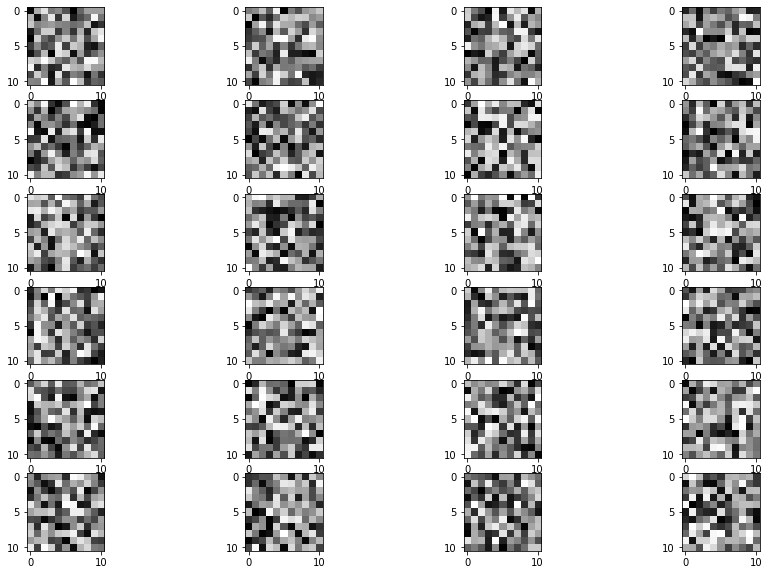

In [68]:
plt.figure(figsize=(15,10))
for s in range(24):
    plt.subplot(6,4,s+1)
    plt.imshow(pcae.templates[s][0].detach().cpu().numpy(), cmap="gray")

## Reconstruction using parts

In [0]:
pcae = PCAE().to(device)
state_dict = torch.load("./gdrive/My Drive/trained_pcae.pth")
pcae.load_state_dict(state_dict)
dataiter = iter(mnist.trainloader)
img, lbl = dataiter.next()
img, lbl = img.to(device), lbl.to(device)

In [0]:
x_m, d_m, z_m, templates, transformed_templates, ll, _ = pcae(img)

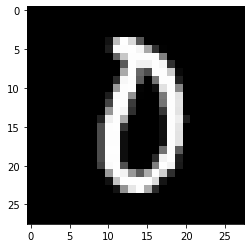

In [77]:
plt.imshow(img[0,0].cpu().numpy(),cmap="gray")

In [78]:
transformed_templates.shape

torch.Size([128, 24, 2, 28, 28])

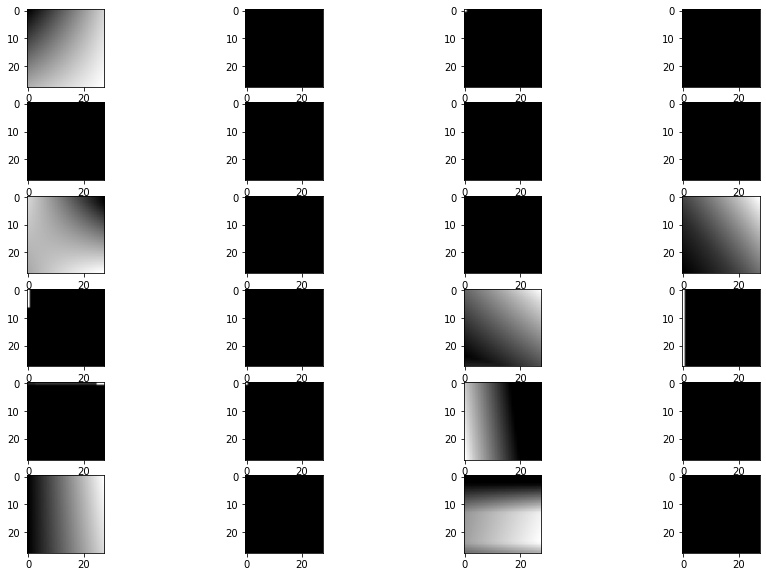

In [81]:
plt.figure(figsize=(15,10))
new_img = torch.zeros((28,28))
for s in range(24):
    plt.subplot(6,4,s+1)
    im = transformed_templates[0,s,0].detach().cpu().numpy()
    new_img += im*d_m[0,s].detach().cpu().numpy()
    plt.imshow(im, cmap="gray")
new_img = new_img/24

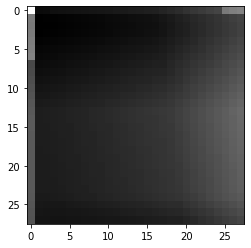

In [82]:
plt.imshow(new_img, cmap="gray")

## Set Transformer Modules

In [0]:
'''
Set Transformer Modules
'''

class MAB(nn.Module):
    def __init__(self, dim_Q, dim_K, dim_V, num_heads, ln=False):
        super(MAB, self).__init__()
        self.dim_V = dim_V
        self.num_heads = num_heads
        self.fc_q = nn.Linear(dim_Q, dim_V)
        self.fc_k = nn.Linear(dim_K, dim_V)
        self.fc_v = nn.Linear(dim_K, dim_V)
        if ln:
            self.ln0 = nn.LayerNorm(dim_V)
            self.ln1 = nn.LayerNorm(dim_V)
        self.fc_o = nn.Linear(dim_V, dim_V)

    def forward(self, Q, K):
        Q = self.fc_q(Q)
        K, V = self.fc_k(K), self.fc_v(K)

        dim_split = self.dim_V // self.num_heads
        Q_ = torch.cat(Q.split(dim_split, 2), 0)
        K_ = torch.cat(K.split(dim_split, 2), 0)
        V_ = torch.cat(V.split(dim_split, 2), 0)

        A = torch.softmax(Q_.bmm(K_.transpose(1,2))/math.sqrt(self.dim_V), 2)
        O = torch.cat((Q_ + A.bmm(V_)).split(Q.size(0), 0), 2)
        O = O if getattr(self, 'ln0', None) is None else self.ln0(O)
        O = O + F.relu(self.fc_o(O))
        O = O if getattr(self, 'ln1', None) is None else self.ln1(O)
        return O

class SAB(nn.Module):
    def __init__(self, dim_in, dim_out, num_heads, ln=False):
        super(SAB, self).__init__()
        self.mab = MAB(dim_in, dim_in, dim_out, num_heads, ln=ln)

    def forward(self, X):
        return self.mab(X, X)

class ISAB(nn.Module):
    def __init__(self, dim_in, dim_out, num_heads, num_inds, ln=False):
        super(ISAB, self).__init__()
        self.I = nn.Parameter(torch.Tensor(1, num_inds, dim_out))
        nn.init.xavier_uniform_(self.I)
        self.mab0 = MAB(dim_out, dim_in, dim_out, num_heads, ln=ln)
        self.mab1 = MAB(dim_in, dim_out, dim_out, num_heads, ln=ln)

    def forward(self, X):
        H = self.mab0(self.I.repeat(X.size(0), 1, 1), X)
        return self.mab1(X, H)

class PMA(nn.Module):
    def __init__(self, dim, num_heads, num_seeds, ln=False):
        super(PMA, self).__init__()
        self.S = nn.Parameter(torch.Tensor(1, num_seeds, dim))
        nn.init.xavier_uniform_(self.S)
        self.mab = MAB(dim, dim, dim, num_heads, ln=ln)

    def forward(self, X):
        return self.mab(self.S.repeat(X.size(0), 1, 1), X)


# Set Transformer
class SetTransformer(nn.Module):
    def __init__(self, dim_input, num_outputs, dim_output,
            num_inds=32, dim_hidden=128, num_heads=4, ln=False):
        super(SetTransformer, self).__init__()
        self.enc = nn.Sequential(
                ISAB(dim_input, dim_hidden, num_heads, num_inds, ln=ln),
                ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=ln))
        self.dec = nn.Sequential(
                PMA(dim_hidden, num_heads, num_outputs, ln=ln),
                SAB(dim_hidden, dim_hidden, num_heads, ln=ln),
                SAB(dim_hidden, dim_hidden, num_heads, ln=ln),
                nn.Linear(dim_hidden, dim_output))

    def forward(self, X):
        return self.dec(self.enc(X))

##OCAE

In [0]:
'''
Object Capsule Autoencoder
'''
class OCAE(nn.Module):
    def __init__(self,dim_input=265,num_capsules=24,set_out=256,set_head=1,special_feat=16):
        super(OCAE,self).__init__()

        self.set_transformer = nn.Sequential( SetTransformer(dim_input,num_capsules,set_out,num_heads=set_head,dim_hidden=16,ln=True),
                                              SetTransformer(set_out,num_capsules,set_out,num_heads=set_head,dim_hidden=16,ln=True),
                                              SetTransformer(set_out,num_capsules,special_feat+1+9,num_heads=set_head,dim_hidden=16,ln=True),
                                                         )
        self.mlps = nn.ModuleList( [ nn.Sequential( nn.Linear(special_feat,special_feat),
                                                     nn.ReLU(),
                                                     nn.Linear(special_feat,48)) for _ in range(num_capsules) ] )
        self.op_mat = Parameter(torch.randn(num_capsules,num_capsules,3,3))
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.epsilon = torch.tensor(1e-6)
    
    def forward(self,inp,x_m,d_m,mode='train'):
        object_parts = self.set_transformer(inp) #(B,K,9+16+1)
        if mode == 'train':
            noise_1 = torch.FloatTensor(*object_parts.size()[:2]).uniform_(-2,2).to(device)
            noise_2 = torch.FloatTensor(object_parts.shape[0],24).uniform_(-2,2).to(device)

        else:
            noise_1 = torch.zeros(*object_parts.size()[:2]).to(device)
            noise_2 = torch.zeros(object_parts.shape[0],24).to(device)

        ov_k = self.relu(object_parts[:,:,:9]).view(*object_parts.size()[:2],1,3,3)
        c_k = self.relu(object_parts[:,:,9:25])
        a_k = self.sigmoid(object_parts[:,:,-1]+noise_1).view(*object_parts.size()[:2],1,1,1)        
        temp_a =[]
        temp_lambda = []
        for num,mlp in enumerate(self.mlps):
            mlp_out = self.mlps[num](c_k[:,num,:])
            temp_a.append(self.sigmoid(mlp_out[:,:24]+noise_2).unsqueeze(1))
            temp_lambda.append(self.relu(mlp_out[:,24:]).unsqueeze(1))
        a_kn = torch.cat(temp_a,1).unsqueeze(-1).unsqueeze(-1) #(B,K,M,1,1)
        lambda_kn = torch.cat(temp_lambda,1).unsqueeze(-1).unsqueeze(-1) #(B,K,M,1,1)
        lambda_kn = lambda_kn*1+self.epsilon #for supressing nan values when taking reciprocal
        v_kn = ov_k.matmul(self.op_mat) #(B,K,M,3,3)
        mu_kn = v_kn.view(*v_kn.size()[:3],-1)[:,:,:,:6] #(B,K,M,6)
        x_m = x_m.unsqueeze(1) #(B,1,M,6)
        diff = (x_m - mu_kn).unsqueeze(-2) #(B,K,M,1,6)
        identity = torch.eye(6).unsqueeze(0).unsqueeze(0).unsqueeze(0).expand(*diff.size()[:3],-1,-1).to(device) #(B,K,M,6,6)
        cov_matrix_inv = (lambda_kn.reciprocal())*identity #(B,K,M,6,6)
        mahalanobis = torch.matmul(torch.matmul(diff,cov_matrix_inv),diff.transpose(-1,-2)) #(B,K,M,1,1)
        gaussian_multiplier = (((2*math.pi)**6)*(lambda_kn**6)).sqrt() #(B,K,M,1,1)
        gaussian = (-0.5*mahalanobis).exp()*gaussian_multiplier.reciprocal() #(B,K,M,1,1)

        gaussian_component = (a_k*a_kn)*((a_k.sum(1).unsqueeze(1)*a_kn.sum(2).unsqueeze(1)).reciprocal()) #(B,K,M,1,1)

        gauss_mix = (gaussian*gaussian_component).squeeze(-1).squeeze(-1) #(B,K,M)
        gauss_mix = (gauss_mix*1.0)+self.epsilon
        before_log = gauss_mix.sum(1).log() #(B,M)
        log_likelihood = (before_log*(d_m.view(before_log.shape[0],-1))).sum(-1).mean() #scalar
        return log_likelihood, a_k.squeeze(-1).squeeze(-1),a_kn.squeeze(-1).squeeze(-1),gaussian.squeeze(-1).squeeze(-1)


class OCAE_LOSS(nn.Module):
    def __init__(self):
        super(OCAE_LOSS,self).__init__()
    def entropy(self,x):
        h = F.softmax(x, dim=-1) * F.log_softmax(x, dim=-1)
        h = -1.0 * h.sum(-1)
        return h.mean()
    def forward(self,output_ocae,b_c,k_c):
        part_lik, a_k, a_kn, gaussian = output_scae
        a_k_prior = (a_k.squeeze(-1))*(a_kn.max(-1).values) #(B,K)
        a_kn_posterior = a_k *(a_kn*gaussian) #(B,K,M)
        l_11 = (a_k_prior.sum(-1)-k_c).pow(2).mean() 
        l_12 = (a_k_prior.sum(0)-b_c).pow(2).mean()
        prior_sparsity = l_11+l_12
        v_k = a_kn_posterior.sum(-1).transpose(0,1)
        v_b = a_kn_posterior.sum(-1)
        posterior_sparsity = self.entropy(v_k)-self.entropy(v_b)
        return -part_lik + prior_sparsity + posterior_sparsity

## SCAE Model

In [0]:
# Stacked Capsule Autoencoder
class SCAE(nn.Module):
    def __init__(self):
        super(SCAE,self).__init__()
        self.pcae = PCAE()
        self.ocae = OCAE()
    def forward(self,x,mode):
        x_m, d_m, z_m, templates, transformed_templates, image_likelihood, input_ocae = self.pcae(x)
        part_likelihood,a_k,a_kn,gaussian = self.ocae(input_ocae,x_m,d_m,mode)
        return image_likelihood,part_likelihood,a_k,a_kn,gaussian


# Loss Functions (Negative Log Likelihoods of Image and Part + Sparsity Losses)
class SCAE_LOSS(nn.Module):
    def __init__(self):
        super(SCAE_LOSS,self).__init__()
    def entropy(self,x):
        h = F.softmax(x, dim=-1) * F.log_softmax(x, dim=-1)
        h = -1.0 * h.sum(-1)
        return h.mean()
    def forward(self,output_scae,b_c,k_c):
        img_lik,part_lik,a_k,a_kn,gaussian = output_scae
        a_k_prior = (a_k.squeeze(-1))*(a_kn.max(-1).values) #(B,K)
        a_kn_posterior = a_k *(a_kn*gaussian) #(B,K,M)
        l_11 = (a_k_prior.sum(-1)-k_c).pow(2).mean() 
        l_12 = (a_k_prior.sum(0)-b_c).pow(2).mean()
        prior_sparsity = l_11+l_12
        v_k = a_kn_posterior.sum(-1).transpose(0,1)
        v_b = a_kn_posterior.sum(-1)
        posterior_sparsity = self.entropy(v_k)-self.entropy(v_b)
        return img_lik, part_lik, prior_sparsity, posterior_sparsity


# Function to view # of parameters
def n_parameters(model):
        return np.sum([np.prod(x.size()) for x in model.parameters()])

## Training

In [0]:
scae = SCAE().to(device)
epochs = 50
optimizer = torch.optim.RMSprop(scae.parameters(),lr=1e-5, eps=1./(10*mnist.trainloader.batch_size)**2)
loss_func = SCAE_LOSS()
n_parameters(scae)

627994

In [0]:
print('Starting')
print('Running for',epochs,'Epochs')
print('Batch Size:', mnist.trainloader.batch_size)
n_of_batches = int(len(mnist.train_data.data)/mnist.trainloader.batch_size)
print('No of batches per epoch:', n_of_batches)
losses = []
test_acc = []
K = 24
C = 24
B = mnist.trainloader.batch_size
k_c = torch.tensor(float(K/C)).to(device)
b_c = torch.tensor(float(B/C)).to(device)
for epoch in range(epochs):
    loss2 = []
    ave_loss = 0
    for i, data in enumerate(mnist.trainloader, 0):
        scae.train()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = scae(inputs,mode='train')
        img_lik, part_lik, prior_sparsity, posterior_sparsity = loss_func(out, b_c, k_c)
        loss = -0.5*img_lik-part_lik+prior_sparsity+(10*posterior_sparsity)
        loss.mean().backward()
        optimizer.step()
        loss2.append(loss.mean().item())
        print("\rEpoch #:",epoch+1, "  Batch #:", i+1, "\tImage Likelihood:","{0:.2f}".format(-0.5*img_lik.item()),
              "\tPart Likelihood:","{0:.2f}".format(-part_lik.item()), "\tPrior Sparsity:","{0:.2f}".format(prior_sparsity.item()), 
              "\tPosterior Sparsity:","{0:.2f}".format(10*posterior_sparsity.item()), end="")
    l = np.sum(loss2)/(len(loss2))
    print('\nEpoch #:', epoch+1, '  Training Loss: ',"{0:.2f}".format(l))
    losses.append(l)
    torch.save(scae.state_dict(), "./gdrive/My Drive/trained_scae.pth")
print('Finished')

Starting
Running for 50 Epochs
Batch Size: 128
No of batches per epoch: 468
Epoch #: 1   Batch #: 469 	Image Likelihood: 4493.04 	Part Likelihood: -39.41 	Prior Sparsity: 128.08 	Posterior Sparsity: 0.68
Epoch #: 1   Training Loss:  4863.13
Epoch #: 2   Batch #: 469 	Image Likelihood: 4492.05 	Part Likelihood: -58.10 	Prior Sparsity: 115.98 	Posterior Sparsity: 0.00
Epoch #: 2   Training Loss:  4733.69
Epoch #: 3   Batch #: 469 	Image Likelihood: 4492.45 	Part Likelihood: -216.18 	Prior Sparsity: 87.59 	Posterior Sparsity: 0.29
Epoch #: 3   Training Loss:  4623.27
Epoch #: 4   Batch #: 469 	Image Likelihood: 895.86 	Part Likelihood: -402.89 	Prior Sparsity: 56.20 	Posterior Sparsity: 0.38
Epoch #: 4   Training Loss:  3929.61
Epoch #: 5   Batch #: 469 	Image Likelihood: 696.96 	Part Likelihood: -575.53 	Prior Sparsity: 48.61 	Posterior Sparsity: 0.00
Epoch #: 5   Training Loss:  346.14
Epoch #: 6   Batch #: 469 	Image Likelihood: 630.45 	Part Likelihood: -631.24 	Prior Sparsity: 37.43 	

## Model Exp

In [0]:
scae = SCAE().to(device)
state_dict = torch.load("./gdrive/My Drive/trained_scae.pth")
scae.load_state_dict(state_dict)
dataiter = iter(mnist.trainloader)
img, lbl = dataiter.next()
img, lbl = img.to(device), lbl.to(device)

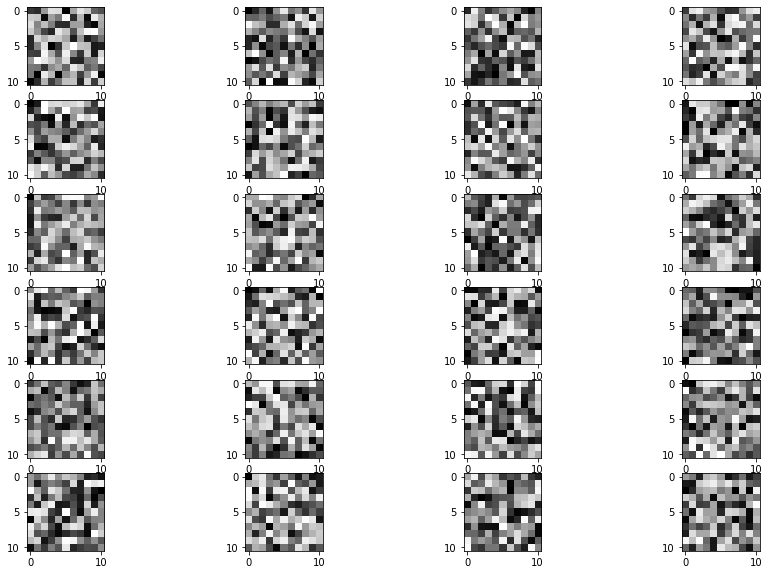

In [0]:
plt.figure(figsize=(15,10))
for s in range(24):
    plt.subplot(6,4,s+1)
    plt.imshow(scae.pcae.templates[s,0].detach().cpu().numpy(), cmap="gray")